## Causality

We have all heard the addage "correlation does not equal causation": so how do we go about making causal claims? Let's step back for a second and think about how -- in the most ideal setting -- we would assess causality?

**Potential Outcomes**
Intuitively, a causal effect is the difference (for a single entity) between that entity's outcome if they were treated and the outcome for that entity if they were not treated. It is the answer to the question: what would have happened to the entity if they had not received treatment? This is known as the **Potential Outcomes** model of causality and is attributed to Ronald Fisher, ...

Now, there is one obvious problem with this formulation: we never get to see the alternative outcome for a particular entity. Fundamentally, we have a missing data problem. To get around the issue, we instead consider the *average* causal effect across many entities, i.e. the **average treatment effect**. We solved one problem, but now we have another one: what if those who receive treatment are fundamentally different from those that do not receive treatment? This issue is known as **selection bias**. All of the methods that will be discussed are geared toward eliminating selection bias so that we can have confidence in our estimate of the average treatment effect. The combination of subject matter expertise (theory), data collection procedures, and statistical methods that we employ in our analysis together form our **identification strategy**. The validity of our results, therefore, comes down to how convincing our identification strategy is.

## Stat-100 Crash Course

The goal of this section is to introduce and/or refresh you on the import concepts that form the basis for many of the methods that will be discussed later. Although analyzing and working with real data are absolutely critical skills, these tutorials use simulation to elucidate concepts. Many of the methods discussed in the following sections rely on strong assumptions about how the data are generated; however, in the real world, the **data generating process** is rarely known with anything close to a high degree of certainty. Simulation provides us a way to ignore the potential pitfalls of those assumptions to develop an intuition about how the methods work. We can then simulate data that violates these assumptions to gain a deeper understanding of the role that these assumptions play.

The running example in these tutorials is to estimate the effect of classroom size on academic achievement. For now, all we need to know is that academic achievement is measured via a standardized test.

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_1samp, ttest_ind
from sklearn.datasets import make_spd_matrix

random.seed(1234)

%matplotlib inline

### Populations and Samples

Let's start by generating a sample of 5,00 students to serve as our "population." Note that the resulting distribution looks like a Bell curve. Since the data are generated by taking random draws from a normal distribution, this is exactly what should happen. This is rare example where we actually know the data-generating process. Normally (pun-intended) we would not **know** exactly how the data are generated. Instead, we are forced to make some assumptions about the data-generating process if we want to do statistical inference and hypothesis testing (more on that later).

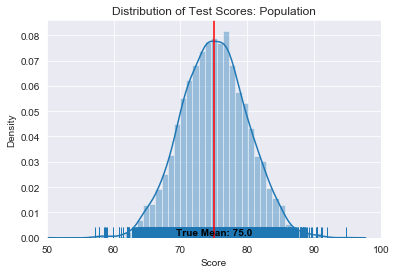

In [2]:
# Note: Even though we are generating this data randomly, we still consider it to be our true "population"
student_population = np.random.normal(loc=75, scale=5, size=5000)\

fig, ax = plt.subplots()
sns.distplot(student_population, rug=True, norm_hist=True, ax=ax)
ax.axvline(75, 0, 1, color="r")
ax.set_title("Distribution of Test Scores: Population")
ax.set_xlabel("Score")
ax.set_xlim(50, 100)
ax.set_ylabel("Density")
ax.text(75, 0.001, "True Mean: {}".format(round(np.mean(student_population))), 
        horizontalalignment='center', 
        size='medium', 
        color='black', 
        weight='semibold')

plt.savefig("./images/student_population.png", dpg=600)

Now, we can take a random sample of students from our population. In general, even if the population of interest could (in theory) be studied, it is usually not logistically feasible to do so. Instead, a random sample from that population is collected and analyzed. Ideally, the properties of the sample will closely approximate the population.

Text(0, 0.5, 'Density')

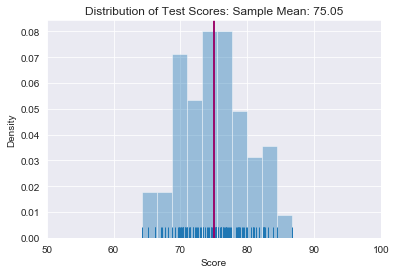

In [3]:
single_sample = np.random.choice(student_population, size=100)

t, p_val = ttest_1samp(single_sample, 75)

fig, ax = plt.subplots()
sns.distplot(single_sample, bins=10, kde=False, rug=True, norm_hist=True, ax=ax)
ax.axvline(75, 0, 1, color="r")
ax.axvline(np.mean(single_sample), 0, 1, color="purple")
ax.set_xlim(50, 100)
ax.set_title("Distribution of Test Scores: Sample Mean: {}".format(round(np.mean(single_sample), 2)))
ax.set_xlabel("Score")
ax.set_ylabel("Density")

We have drawn a random sample of 100 students from our population of 5,000. Our currently goal is to estimate the population mean from this sample. What are some different ways that we could do this?
- Take the ith value from the sample
- Use the mode of the sample
- Use the mean of the sample

Each of these methods are an **estimator** for the population mean. An estimator is simply a function of the sample data, i.e. it is an **algorithm** for achieving some estimate. Applying the method to the sample results in an **estimate** of the poppulation mean. Since samples are random, an estimate is a **random variable**. 

Which method do you think is best? How would you even define best? Typically, one estimator is better than another if the estimate can be expected to be closer to the true population that the estimate from some other estimator. An estimate that can be proven to be close to the thing being estimated (except for random chance) is **unbiased**. As it turns out, the sample mean is the __best linear unbiased estimator__ of the population mean. Another important property is that the estimate has the lowest possible variance. Given two estimators that produce unbiased estimates, the estimator with a lower expected variance is prefferred.

Take a look at the figure below to see how sample size is related to how close the estimate is to the true value:


Text(0, 0.5, 'Sample Mean')

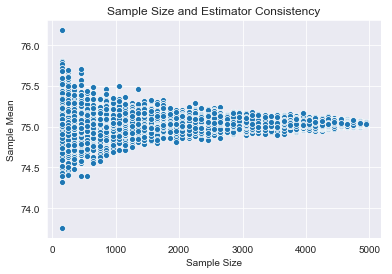

In [4]:
sample_sizes = np.arange(150, 5000, 100)
x = []
y = []
n_per_sample_size = 100
for s in sample_sizes:
    for i in range(n_per_sample_size):
        sample = np.random.choice(student_population, size=s, replace=False)
        x.append(s)
        y.append(np.mean(sample))

sample_data = pd.DataFrame(zip(x, y), columns=["sample_size", "sample_mean"])
mean_data = sample_data.groupby(by="sample_size").mean().reset_index()

fig, ax = plt.subplots()
sns.scatterplot(x="sample_size", y="sample_mean", data=sample_data)
ax.set_title("Sample Size and Estimator Consistency")
ax.set_xlabel("Sample Size")
ax.set_ylabel("Sample Mean")

This plot illustrates the **Law of Large Numbers**. Stated simply, it says that as the sample size increases, the sample mean will be close to the population mean. In a similar vein, we can say that the sample mean is a **consistent** estimator of the population mean if if converges tin probability to the population parameter.

Although we have discussed sample means so far, we can apply similar ideas to estimating the population variance. There are also many possible estimators for the population variance, however, the most common one is the sample standard deviation.

Fun Facts from Mathematical Statistics:
-  It is possible for an estimator to be unbiased, but not consistent and vice versa. They are related properties, but one does not necessarily imply the other.
- A mean is the **first moment**, while the variance is the **second moment**. Skewness (skew) is the **third moment** and kurtosis is the **fourth moment** of a distribution. In fact, for many common distributions, there are analytical expressions for these moments, referred to as **moment generating functions**. 
- An estimator is a **statistic** and that statistic is **sufficient** if no other statistic that can be calculated from the sample provides any extra information about the population parameter of interest. Sufficiency can also be defined in terms of a Markov chain: $\theta \rightarrow T(X) \rightarrow X$

### NHST: Null Hypothesis Significance Testing

To have a sample and a population is all well and good, but what is the point of sampling from a population any way? Often, we want to compare a single group to some important threshold, or we want to compare two groups along some particular dimension? The other restriction is that -- for one reason or another -- we can only observe a sample of the population of interest. How can we know if the differences that we see between groups are due to chance or arise because the populations are actually different? The NHST framework is one solution to such a problem.

Let's take another look at the random sample from before:

Text(0, 0.5, 'Density')

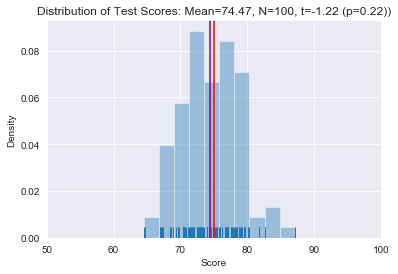

In [5]:
single_sample = np.random.choice(student_population, size=100)

t, p_val = ttest_1samp(single_sample, 75)

fig, ax = plt.subplots()
sns.distplot(single_sample, bins=10, kde=False, rug=True, norm_hist=True, ax=ax)
ax.axvline(75, 0, 1, color="r")
ax.axvline(np.mean(single_sample), 0, 1, color="purple")
ax.set_xlim(50, 100)
ax.set_title("Distribution of Test Scores: Mean={}, N=100, t={} (p={}))".format(
    round(np.mean(single_sample), 2), round(t, 2), round(p_val, 2)))
ax.set_xlabel("Score")
ax.set_ylabel("Density")

Notice the test statistic and p-value listed in the figure title. The NHST framework has a few key components. First, the **null hypothesis** is the hypothesis that you would like to test. For example, one null hypothesis could be that the average test scores in our population is 75.

The observed sample provides evidence that may support or contradict the null hypothesis. Since there is randomness introduced from sampling, we cannot use the raw difference between the sample mean and the null hypothesis to make a claim about the relationship between the population mean and the null hypothesis. Instead, we construct a **test statistic** from the sample mean and an associated **p value**. A **p value** is the probability of achieving at least as extreme a value as the observed test statistic assuming that the null hypothesis were correct.

Try running the above cell a few more times and notice how the value of the test statistic and p-value change. Try running the cell a few more times. Do you ever see a p value less than .1?

As you can probably deduce by now, the NHST is not a fool-proof method. It is certainly possible for us to get things wrong. There are a few bits of terminology that you should be aware of that all related to __how__ things could go wrong:

- The **power** of a test is the probability that the test correctly rejects the null hypothesis when the alternative is true. The sample size and true value of the unknown parameter are key inputs to any power calculation
- **Type I Error** -- The probability that the null hypothesis is rejected when the alternative is true
- **Type II Error** -- The probability that the null hypothesis is **not** rejected when it is false


Notes:

Although Type I and II error are the most commonly taught errors, two additional errors are talked about in more contemporary dialogues:

- Type S Error: Claiming an incorrect sign for an estimate
- Type M Error: Claiming an incorrect magnitude for an estimate

So far, we have talked about a single sample from a population. To better understand the concepts thus far, let's simulate the theoretical situation where we can collect __many__ samples.

Text(0.905, 0.8, '0.10: 6/1000 (0.01)')

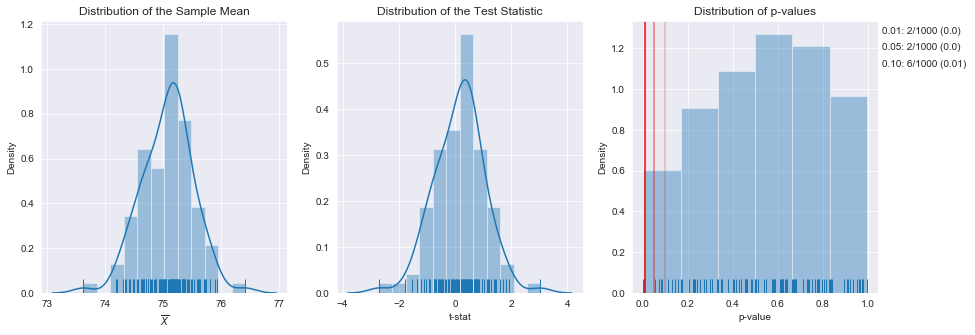

In [6]:
repeated_samples = np.random.choice(student_population, size =(100, 100))
sample_means = np.mean(repeated_samples, axis=0)
t_stats, p_vals = ttest_1samp(repeated_samples, 75)

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

sns.distplot(sample_means, kde=True, rug=True, norm_hist=True, ax=ax[0])
ax[0].set_title("Distribution of the Sample Mean")
ax[0].set_xlabel("$\overline{X}$")
ax[0].set_ylabel("Density")

sns.distplot(t_stats, kde=True, rug=True, norm_hist=True, ax=ax[1])
ax[1].set_title("Distribution of the Test Statistic")
ax[1].set_xlabel("t-stat")
ax[1].set_ylabel("Density")

sns.distplot(p_vals, kde=False, rug=True, norm_hist=True, ax=ax[2])
ax[2].set_title("Distribution of p-values")
ax[2].set_xlabel("p-value")
ax[2].set_ylabel("Density")
ax[2].axvline(0.01, 0, 1, color="r", alpha=1.0)
ax[2].axvline(0.05, 0, 1, color="r", alpha=0.5)
ax[2].axvline(0.10, 0, 1, color="r", alpha=0.25)

thresh_01 = len(np.where(p_vals < 0.01)[0])
thresh_05 = len(np.where(p_vals < 0.05)[0])
thresh_10 = len(np.where(p_vals < 0.10)[0])

ax[2].annotate('0.01: {}/1000 ({})'.format(thresh_01, round(thresh_01 / 1000, 2)), 
               xy=(.905, .9), 
               xycoords="figure fraction")
ax[2].annotate('0.05: {}/1000 ({})'.format(thresh_05, round(thresh_05 / 1000, 2)), 
               xy=(.905, .85), 
               xycoords="figure fraction")
ax[2].annotate('0.10: {}/1000 ({})'.format(thresh_10, round(thresh_10 / 1000, 2)), 
               xy=(.905, .80), 
               xycoords="figure fraction")

The plots come from drawing 100 different samples of 100 students each, all from the same population. As noted before, the sample mean is itself a random variable. The set of observed sample means from repeatedly taking samples from the population is referred to as the **sampling distribution**. The left plot shows the empirical sampling distribution from our simulation. For small sample sizes, it can be shown that the sampling distribution follows a student's T distribution. However, for large sample sizes (think  n > 100), the t-distribution closely approximates a normal distribution. 

For a lot of hypothesis testing (especially in the econometrics world), a normal distribution is assumed since sample sizes tend to be fairly large. This asumption is justified by the **central limit theorem**, which says that when the sample size is large, the sampling distribution of the sample mean is approximately normal. Also not that since the test statistic is a function of the sample mean, the central limit theorem says that the sampling distribution is normally distributed. This can be seen in the middle plot above.

The far right plot shows the distribution of p-values calculated from test statistics. It is a pictoral representation of the definition of a p-value, i.e. the  probability of achieving at least as extreme a value as the observed test statistic assuming that the null hypothesis were correct. The null hypothesis we are testing is that the sample mean is equal to 75. As expected, the number of samples that would cause us to reject the null is approximately equal to the chosen threshold. It should be clear that there is nothing special about any particular threshold. In fact, the choice is completely arbitrary. No threshold is theoretically better than any other.